In [1]:
import pymc3 as pm
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import theano.tensor as tt

sns.set(style='white', palette='deep', color_coes=True)
%matplotlib inline

1 #define _CUDA_NDARRAY_C
2 
3 #include <Python.h>
4 #include <structmember.h>
5 #include "theano_mod_helper.h"
6 
7 #include <numpy/arrayobject.h>
8 #include <iostream>
9 
10 #include "cuda_ndarray.cuh"
11 
12 #ifndef CNMEM_DLLEXPORT
13 #define CNMEM_DLLEXPORT
14 #endif
15 
16 #include "cnmem.h"
17 #include "cnmem.cpp"
18 
19 //If true, when there is a gpu malloc or free error, we print the size of allocated memory on the device.
20 #define COMPUTE_GPU_MEM_USED 0
21 
22 //If true, we fill with NAN allocated device memory.
23 #define ALLOC_MEMSET 0
24 
25 //If true, we print out when we free a device pointer, uninitialize a
26 //CudaNdarray, or allocate a device pointer
27 #define PRINT_FREE_MALLOC 0
28 
29 //If true, we do error checking at the start of functions, to make sure there
30 //is not a pre-existing error when the function is called.
31 //You probably need to set the environment variable
32 //CUDA_LAUNCH_BLOCKING=1, and/or modify the CNDA_THREAD_SYNC
33 //preprocessor macro 

334                     ptr,
335                     cudaGetErrorString(err));
336             return -1;
337         }
338     }
339     _outstanding_mallocs[0] -= (ptr != NULL);
340     #if COMPUTE_GPU_MEM_USED
341         int i=0;
342         size_t total_freed = 0;
343         for(;i<TABLE_SIZE;i++)
344             if(_alloc_size_table[i].ptr==ptr){
345                 _allocated_size -= _alloc_size_table[i].size;
346                 total_freed += _alloc_size_table[i].size;
347                 _alloc_size_table[i].ptr=0;
348                 _alloc_size_table[i].size=0;
349 
350                 break;
351             }
352         //if(i==TABLE_SIZE)
353         //    printf("Unallocated unknow size!\n");
354         //fprintf(stderr, "freed %li bytes of device memory (%s). %d already allocated, ptr=%p\n", (long)total_freed, cudaGetErrorString(err),_allocated_size,ptr);
355     #endif
356     return 0;
357 }
358 
359 static PyObject *
360 outstanding_mallocs(PyObject* self, PyObjec

1491     CudaNdarray * self = (CudaNdarray *)py_self;
1492     CudaNdarray * other = (CudaNdarray *)py_other;
1493     if(!CudaNdarray_is_c_contiguous(self) || !CudaNdarray_is_c_contiguous(other)){
1494         PyErr_SetString(PyExc_TypeError, "We have implementet only the c_contiguous version for now.");
1495         return NULL;
1496     }
1497 
1498     //standard elemwise size checks
1499     if (self->nd != other->nd)
1500     {
1501         PyErr_SetString(PyExc_TypeError, "CudaNdarray_add: need same number of dims");
1502         return NULL;
1503     }
1504     //standard elemwise dim checks
1505     unsigned int size = 1;
1506     for (int i = 0; i< self->nd; ++i)
1507     {
1508         if (CudaNdarray_HOST_DIMS(self)[i] != CudaNdarray_HOST_DIMS(other)[i])
1509         {
1510             PyErr_SetString(PyExc_TypeError, "need same dimensions");
1511             return NULL;
1512         }
1513         size *= (unsigned int) CudaNdarray_HOST_DIMS(self)[i];
1514     }
1515     

2567             PyErr_SetString(PyExc_NotImplementedError,
2568                  "CudaNdarray.__setitem__: When the new value is a scalar"
2569                  " of value 0 the part where we copy to must be c contiguous.");
2570             Py_XDECREF(rval);
2571             return -1;
2572         }
2573 
2574         long val = PyInt_AsLong(intobj);
2575         Py_DECREF(intobj); intobj=NULL;
2576         if (val == 0)
2577         {
2578             cudaError_t err = cudaMemset(rval->devdata, 0,
2579                                          CudaNdarray_SIZE(rval) * sizeof(real));
2580             Py_XDECREF(rval);
2581             if (err)
2582             {
2583                 // Clear the error flag, cudaMemset doesn't do it.
2584                 // Currently this returns the same thing as err, but if in future
2585                 // it returns something else I still don't see why we should ignore
2586                 // it.  All we want to do here is reset the flag.
2587    

4020                         return -1;
4021                     }
4022                 }
4023 
4024                 // The blocks implement the looping over the first two axes so
4025                 // this needs to be (N1, N2)
4026                 dim3 n_blocks( std::min(CudaNdarray_HOST_DIMS(self)[0],
4027                                         NUM_VECTOR_OP_BLOCKS),
4028                                std::min(CudaNdarray_HOST_DIMS(self)[1],
4029                                         NUM_VECTOR_OP_BLOCKS));
4030                 // For the threads, just make as many as possible
4031                 dim3 n_threads( std::min( (unsigned int) CudaNdarray_HOST_DIMS(self)[2],
4032                                  (unsigned int) NUM_VECTOR_OP_THREADS_PER_BLOCK),
4033                                 std::min( (unsigned int) CudaNdarray_HOST_DIMS(self)[3],
4034                                     (unsigned int) NUM_VECTOR_OP_THREADS_PER_BLOCK));
4035 
4036                 n_threads.x = s

5259 {
5260     return self->devdata;
5261 }
5262 
5263 /**
5264  * Return the number of elements in the ndarray (product of the dimensions)
5265  */
5266 size_t
5267 CudaNdarray_SIZE(const CudaNdarray *self)
5268 {
5269     if (self->nd == -1) return 0;
5270     size_t size = 1;
5271     for (int i = 0; i < self->nd; ++i)
5272     {
5273         size *= CudaNdarray_HOST_DIMS(self)[i];
5274     }
5275     return size;
5276 }
5277 
5278 PyObject *
5279 CudaNdarray_SIZE_Object(const CudaNdarray *self, void *closure)
5280 {
5281     return PyInt_FromLong(CudaNdarray_SIZE(self));
5282 }
5283 
5284 int CudaNdarray_set_device_data(CudaNdarray * self, float * data, const CudaNdarray * base)
5285 {
5286     return CudaNdarray_set_device_data(self, data, (PyObject *) base);
5287 }
5288 
5289 PyObject * CudaNdarray_IS_C_Contiguous(CudaNdarray * self)
5290 {
5291     return PyBool_FromLong(CudaNdarray_is_c_contiguous(self));
5292 }
5293 
5294 int fprint_CudaNdarray(FILE * fd, const CudaNdarray *s

nvcc fatal   : Cannot find compiler 'cl.exe' in PATH

['nvcc', '-shared', '-O3', '--use-local-env', '--cl-version=2015', '-Xlinker', '/DEBUG', '-D HAVE_ROUND', '-m64', '-Xcompiler', '-DCUDA_NDARRAY_CUH=m18715462c72ed6afcd7ca5d52813ce90,-DNPY_NO_DEPRECATED_API=NPY_1_7_API_VERSION,/Zi,/MD', '-I"C:\\Users\\ares\\Anaconda3\\lib\\site-packages\\theano\\sandbox\\cuda"', '-I"C:\\Users\\ares\\Anaconda3\\lib\\site-packages\\numpy\\core\\include"', '-I"C:\\Users\\ares\\Anaconda3\\include"', '-I"C:\\Users\\ares\\Anaconda3\\lib\\site-packages\\theano\\gof"', '-L"C:\\Users\\ares\\Anaconda3\\libs"', '-L"C:\\Users\\ares\\Anaconda3"', '-o', 'C:\\Users\\ares\\AppData\\Local\\Theano\\compiledir_Windows-10-10.0.16299-SP0-Intel64_Family_6_Model_158_Stepping_9_GenuineIntel-3.6.3-64\\cuda_ndarray\\cuda_ndarray.pyd', 'mod.cu', '-lcublas', '-lpython36', '-lcudart']


C:\Users\ares\Anaconda3\lib\site-packages\h5py\__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


TypeError: set() got an unexpected keyword argument 'color_coes'

In [60]:
n = 30
X0 = np.sort(3*np.random.rand(n))[:, None]

m = 100
X = np.linspace(0, 3, m)[:, None]

In [61]:
noise = 0.1
lengthscale = 0.3
f_scale = 1

cov = f_scale*pm.gp.cov.ExpQuad(1, lengthscale)

In [62]:
K = cov(X0)
K_s = cov(X0, X)
K_noise = K + noise * tt.eye(n)

In [63]:
K_stable = K + 1e-12 * tt.eye(n) # noise for stability on diagonal

In [64]:
# observed data
f = np.random.multivariate_normal(mean=np.zeros(n), cov=K_noise.eval())

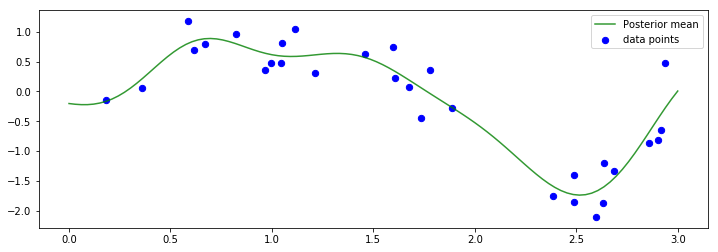

In [65]:
fig, ax = plt.subplots(figsize=(12,4));
ax.scatter(X0, f, s=40, color='b', label='data points');

L = np.linalg.cholesky(K_noise.eval()) # analytical posterior mean
alpha = np.linalg.solve(L.T, np.linalg.solve(L, f))
post_mean = np.dot(K_s.T.eval(), alpha)

ax.plot(X, post_mean, color='g', alpha=0.8, label='Posterior mean');
ax.legend()

In [66]:
with pm.Model() as model:
    f_sample = pm.Flat('f_sample', shape=(n,))
    
    # Likelihood
    y = pm.MvNormal('y', observed=f, mu=f_sample, cov=noise * tt.eye(n), shape=n)
    L = tt.slinalg.cholesky(K_noise)
    f_pred = pm.Deterministic('f_pred', tt.dot(K_s.T, tt.slinalg.solve(L, f_sample)))
    
    ess_step = pm.EllipticalSlice(vars=[f_sample], prior_cov=K_stable)
    trace = pm.sample(10000, start=model.test_point, step=[ess_step])

100%|███████████████████████████████████████████████████████████████████████████| 10500/10500 [00:43<00:00, 242.08it/s]


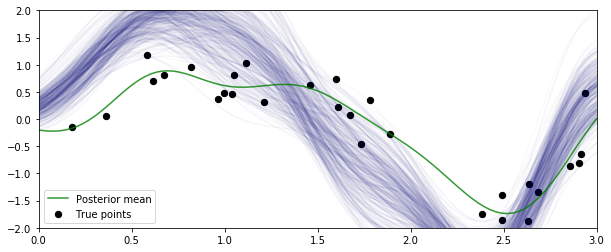

In [67]:
fig, ax = plt.subplots(figsize=(10, 4));
for idx in np.random.randint(4000, 5000, 500):
    ax.plot(X, trace['f_pred'][idx],  alpha=0.02, color='navy')
ax.scatter(X0, f, s=40, color='k', label='True points');
ax.plot(X, post_mean, color='g', alpha=0.8, label='Posterior mean');
ax.legend();
ax.set_xlim(0, 3);
ax.set_ylim(-2, 2);